In [1]:
# Colab ortamından Google Drive ile bağlantı sağlanıyor.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# gerekli kütüphaneler (contractions ve transformers) kurulur.
# -q bayrağı, kurulum işlemlerini sessiz modda gerçekleştirmek için kullanılır.
!pip install contractions -q
!pip install transformers -q

In [3]:
# Githubdan whisper kütüphanesi indirilir.
! pip install git+https://github.com/openai/whisper.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
# Whisper kütüphanesi önceden eğitilmiş bir dil modeli olan whisper modelini ve 
# torch kütüphanesi de GPU kullanılabilirliğini kontrol etmek için kullanılır.
import whisper
import torch
# Cihazı CUDA GPU veya CPU olarak belirleme
device = "cuda" if torch.cuda.is_available() else "cpu"
# "medium" boyutunda bir dil modeli yükleme ve belirtilen cihazı kullanma
model = whisper.load_model("medium", device=device)

In [5]:
#ses kaydını okur, çeviri yaparak metne dönüştürülmüş halini yazdırır.
result = model.transcribe("/content/drive/MyDrive/MantraAI/audio/3.mp3", task = "translate")
print(result["text"])

 I feel tired, helpless and hopeless.


In [6]:
# Metni "speech_sentence" değişkenine atar.
speech_sentence = result["text"]

In [7]:
# metin işleme için gerekli kütüphaneler 
# (numpy, pandas, nltk, contractions, re, 
# tensorflow, matplotlib.pyplot) içe aktarılır.
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
import re
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
# 'twitter_emotion_dataset.csv' veriseti dosyası okunur ve data değişkenine atanır.
data = pd.read_csv('/content/drive/MyDrive/MantraAI/twitter_emotion_dataset.csv')
data.head()  #varsayılan olarak data verisinin ilk beş satırı görüntülenir.

,content,sentiment
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [9]:
data.columns #data verisinin sütun başlıkları döndürür.

Index(['content', 'sentiment'], dtype='object')

In [10]:
data.shape #data verisinin boyutu (satır ve sütun sayısı) görüntülenir.

(20000, 2)

In [11]:
# Sentiment değerlerine karşılık gelen sayıları duyguyu ifade eden kelimelere döndürür.
def convert_sentiment(value):
    if value == 0:
        return "sadness"
    elif value == 1:
        return "joy"
    elif value == 2:
        return "love"
    elif value == 3:
        return "anger"
    elif value == 4:
        return "fear"
    elif value == 5:
        return "surprise"
    else:
        return ""
        

In [12]:
# data verisindeki 'sentiment' sütunu, convert_sentiment() işlevi uygulanarak güncellenir.
data['sentiment'] = data['sentiment'].apply(convert_sentiment)

In [13]:
# data verisinden rastgele 10 örnek görüntülenir.
print(data.sample(10))

                                                 content sentiment
3083               i feel that people are a shamed of me   sadness
11141  i just go into these modes where i want to wri...     anger
7917   i feel uncontrollably agitated and i have no i...      fear
15043  i can sit here and say its a warm feeling that...       joy
15656          id feel nostalgic about gillard hours ago      love
4666   i sleep in a dreamy state waking up feeling da...  surprise
1313   i feel so blessed to have both lisa and god as...       joy
11749  i feel so unimportant to all of them they all ...   sadness
12435             i am feeling genuinely proud of myself       joy
3210   i changed i feel that im taking advantage of h...     anger


In [14]:
# sentiment sütununa göre gruplandırılan verinin boyutu görüntülenir.
print(data.groupby('sentiment').size())

sentiment
anger       2709
fear        2373
joy         6761
love        1641
sadness     5797
surprise     719
dtype: int64


In [15]:
# data verisi karıştırılır ve indeksler sıfırlanır.
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [16]:
# data eğitim, test ve doğrulama verisi olarak bölmek için oranlanır.
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

train_size = int(train_ratio * len(data))
val_size = int(val_ratio * len(data))
test_size = len(data) - train_size - val_size

In [17]:
# train_data, val_data ve test_data değişkenlerine belirtilen oranlara göre bölünmüş veriler atanır.
train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

In [18]:
# train_data verisinin boyutu görüntülenir.
train_data.shape

(14000, 2)

In [19]:
# preprocess fonksiyonu verilen bir metni ön işleme adımlarından geçirerek metin veri temizliği ve düzenlemesi yapar. 
# stopword'leri atar, harf dışı karakterleri atar, kelimelerin köklerini bulur. 
# bu şekilde metindeki gürültüleri atarak metni tokenlemek için hazır hale getirir.
def preprocess(sentence):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    sentence = re.sub('[^A-z]', ' ', sentence) 
    negative = ['not', 'neither', 'nor', 'but', 'however', 'although', 'nonetheless', 'despite', 'except',
                'even though', 'yet']
    stop_words = [z for z in stop_words if z not in negative]
    preprocessed_tokens = [lemmatizer.lemmatize(contractions.fix(temp.lower())) for temp in sentence.split() if
                           temp not in stop_words]  # lemmatization
    return ' '.join([x for x in preprocessed_tokens]).strip()


In [20]:
# datalardaki 'content' sütunları, preprocess() işlevi uygulanarak güncellenir.
train_data['content'] = train_data['content'].apply(preprocess)
val_data['content'] = val_data['content'].apply(preprocess)
test_data['content'] = test_data['content'].apply(preprocess)

<ipython-input-20-44ab6ea56458>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['content'] = train_data['content'].apply(preprocess)
<ipython-input-20-44ab6ea56458>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['content'] = val_data['content'].apply(preprocess)
<ipython-input-20-44ab6ea56458>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [21]:
train_data['content']

0        noticed several month ago start feeling resent...
1        love lot different kind sport love hanging fri...
2                         feel even killed agonized extent
3                    feel numb way wound really start hurt
4        feel happy inspired little si love reading wri...
                               ...                        
13995                          say feel like i am tortured
13996    trying think anywhere else i have made feel aw...
13997    still feel shaky worst hit area damage destruc...
13998    think feel flushing alarmed headache medicine ...
13999                              like feeling devastated
Name: content, Length: 14000, dtype: object

In [22]:
# Azınlık sınıfından rastgele seçilen örneklerin eklenmesiyle veri seti dengelenir.
# Bir örnekleme nesnesi ros oluşturulur, bu yöntemle eğitim verileri dengelenir.
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(np.array(train_data['content']).reshape(-1, 1), np.array(train_data['sentiment']).reshape(-1, 1))
train = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['content', 'sentiment'])

In [23]:
# Duygu sınıflarını çoklu sınıf kodlamasına dönüştürmek için pd.get_dummies() fonksiyonu kullanılır.
y_train = pd.get_dummies(train['sentiment']).values
y_test = pd.get_dummies(test_data['sentiment']).values
y_val = pd.get_dummies(val_data['sentiment']).values

In [24]:
y_train

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [25]:
# Hugging Face tarafından sağlanan transformers kütüphanesini kullanarak 
# "roberta-base" adlı önceden eğitilmiş bir Roberta modeli için bir tokenizer oluşturur.
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

In [26]:
# verilen örnek metni Roberta tokenizer'ı kullanarak tokenlara böler.
tokenizer.tokenize("Bir milleti yaşatan can damarlarından biri sanattır kuşkusuz.")

['Bir',
 'Ġmil',
 'let',
 'i',
 'Ġya',
 'ÅŁ',
 'atan',
 'Ġcan',
 'Ġdam',
 'arl',
 'ar',
 'Ä±',
 'nd',
 'an',
 'Ġb',
 'iri',
 'Ġsan',
 'att',
 'Ä±',
 'r',
 'Ġk',
 'u',
 'ÅŁ',
 'kus',
 'uz',
 '.']

In [27]:
tokenizer.tokenize("I feel tired, helpless and hopeless. Tokenization example")

['I',
 'Ġfeel',
 'Ġtired',
 ',',
 'Ġhelpless',
 'Ġand',
 'Ġhopeless',
 '.',
 'ĠToken',
 'ization',
 'Ġexample']

In [59]:
# Hugging Face tarafından sağlanan transformers kütüphanesini kullanarak 
# "bert-base-uncased" adlı önceden eğitilmiş bir Bert modeli için bir tokenizer oluşturur.
from transformers import BertTokenizer
Bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [60]:
# verilen örnek metni Bert tokenizer'ı kullanarak tokenlara böler.
Bert_tokenizer.tokenize("Bir milleti yaşatan can damarlarından biri sanattır kuşkusuz.")

['bi',
 '##r',
 'mill',
 '##eti',
 'ya',
 '##sat',
 '##an',
 'can',
 'dam',
 '##ar',
 '##lar',
 '##ı',
 '##nda',
 '##n',
 'bi',
 '##ri',
 'san',
 '##att',
 '##ı',
 '##r',
 'ku',
 '##sk',
 '##us',
 '##uz',
 '.']

In [61]:
Bert_tokenizer.tokenize("I feel tired, helpless and hopeless. Tokenization example.")

['i',
 'feel',
 'tired',
 ',',
 'helpless',
 'and',
 'hopeless',
 '.',
 'token',
 '##ization',
 'example',
 '.']

In [28]:
# roberta_encode fonksiyonu, veriyi tokenize edip 
# Roberta modelin işleyebileceği şekilde vektörleştirir.
def roberta_encode(data, maximum_length):
    input_ids = []
    attention_masks = []

    for content in data.content:
        encoded = encode_text(content, maximum_length)
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

# encode_text fonksiyonu metni kodlamak için tokenizer.encode_plus() yöntemini kullanır.
def encode_text(text, maximum_length):
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        return_attention_mask=True,
      )
    return encoded


In [29]:
X_train.shape

(28284, 1)

In [30]:
y_train.shape

(28284, 6)

In [31]:
#max_len değişkenine train_data['content'] içindeki en uzun metnin kelime sayısı bulunup atanır.
max_len = max([len(x.split()) for x in train_data['content']])
#eğitim, test ve doğrulama verileri sayısallaştırılır.
train_input_ids,train_attention_masks = roberta_encode(train, max_len)
test_input_ids,test_attention_masks = roberta_encode(test_data, max_len)
val_input_ids,val_attention_masks = roberta_encode(val_data, max_len)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [32]:
print('Original: ', X_train[0])

Original:  ['noticed several month ago start feeling resentful walked toward pedestrian crossing intention course crossing road']


In [33]:
print(train_input_ids[0])


[    0 47202   484   353   536   386  2157 31379  2650  3203  1706 11038
  6724  6589   768  6724   921     2     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1]


In [34]:
print(train_attention_masks[0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


In [35]:
# bu fonksiyon ile Roberta modelini kullanarak bir duygu analizi modeli oluşturulur.
def create_model(roberta_model, max_len):
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    output = roberta_model([input_ids,attention_masks])
    output = output[1]

    output = tf.keras.layers.Dense(6, activation='softmax')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(learning_rate=1e-5), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
    return model

In [36]:
#  Transformers kütüphanesinden TFRobertaModel sınıfı kullanarak bir Roberta modeli oluşturulur
# ve bu modeli kullanarak bir model eğitimi gerçekleştirilir.
from transformers import TFRobertaModel
roberta_model = TFRobertaModel.from_pretrained('roberta-base')
model = create_model(roberta_model, max_len)
#Model, eğitim verileri üzerinde belirtilen sayıda epoch ve iterasyon sayısıyla eğitilir.
history = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=5,batch_size=100)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/5
283/283 [==============================] - 309s 917ms/step - loss: 0.6434 - accuracy: 0.7472 - val_loss: 0.2395 - val_accuracy: 0.9163
Epoch 2/5
283/283 [==============================] - 244s 862ms/step - loss: 0.1648 - accuracy: 0.9392 - val_loss: 0.1946 - val_accuracy: 0.9277
Epoch 3/5
283/283 [==============================] - 242s 854ms/step - loss: 0.1254 - accuracy: 0.9516 - val_loss: 0.2100 - val_accuracy: 0.9310
Epoch 4/5
283/283 [==============================] - 244s 861ms/step - loss: 0.1000 - accuracy: 0.9600 - val_loss: 0.1851 - val_accuracy: 0.9297
Epoch 5/5
283/283 [==============================] - 244s 862ms/step - loss: 0.0806 - accuracy: 0.9683 - val_loss: 0.2137 - val_accuracy: 0.9327


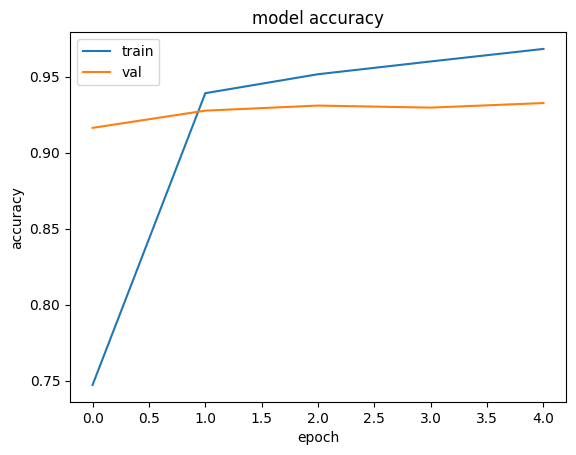

In [37]:
#Eğitim sırasında elde edilen doğruluk değerleri grafikleştirilir.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

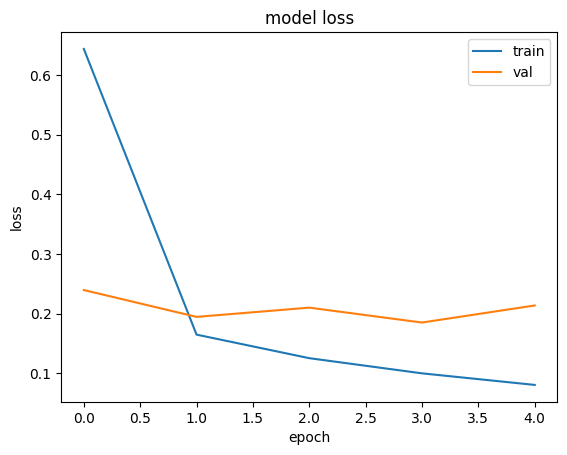

In [38]:
#Eğitim sırasında elde edilen kayıp değerleri grafikleştirilir.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [39]:
# modelin tahminlerini kullanarak test verisi üzerinde sınıflandırma yapılır.
result = model.predict([test_input_ids, test_attention_masks])
y_pred = np.eye(result.shape[1])[np.argmax(result, axis=1)]

94/94 [==============================] - 13s 104ms/step


In [40]:
# sınıflandırma tahminlerinin doğruluğu hesaplanır.
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy', accuracy)

Accuracy 0.9233333333333333


In [41]:
#eğitilmiş model kaydedilir.
model.save('my_MantraAI_model')

In [42]:
# verilen metnin Roberta modeliyle uyumlu hale getirilmesi için kodlama(vektörleştirme) yapılır.
def roberta_inference_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []
  
    encoded = tokenizer.encode_plus(
    data,
    add_special_tokens=True,
    max_length=maximum_length,
    pad_to_max_length=True,
    return_attention_mask=True
    )
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [43]:
# metin cümlesi ön işlemden geçirilerek kodlanır ve duygu tahmini yaptırılır.
def inference(text_sentence, max_len):
    preprocessed_text = preprocess(text_sentence)
    input_ids, attention_masks = roberta_inference_encode(preprocessed_text, maximum_length=max_len)
    model = create_model(roberta_model, max_len)
    model.load_weights('my_MantraAI_model')
    result = model.predict([input_ids, attention_masks])

    # kategori etiketleri için get_dummies ile oluşturulan kolon isimleri listelenerek kullanılır.
    category_labels = pd.get_dummies(train['sentiment']).columns.tolist()
    # tahmin sonuçları, kategori etiketlerini ve ilgili duygusal puanları içeren 
    # bir DataFrame olarak düzenlenir ve döndürülür.
    result = pd.DataFrame(dict(zip(category_labels, [round(x*100, 2) for x in result[0]])).items(), columns=['emotion', 'rate'])
    return result


In [44]:
#hatırlatma yapmak için speech_text ekrana yazdırılır.
print(speech_sentence)

 I feel tired, helpless and hopeless.


In [45]:
#inference fonksiyonu ile metin cümlesinin duygusal tahmini yaptırılıp ekrana yazdırılır.
result = inference(speech_sentence, max_len)
print(result)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 3s 3s/step
    emotion   rate
0     anger   0.03
1      fear   0.00
2       joy   0.01
3      love   0.00
4   sadness  99.96
5  surprise   0.00


In [46]:
# en yüksek puanlı duygu kategorisi bi değişkene atanarak yazdırılır.
highest_rate_emotion = result.loc[result['rate'].idxmax(), 'emotion']
print(highest_rate_emotion)


sadness


In [47]:
# Mantralar dosyası okunur ve mantra_excel'e atanır.
mantra_excel = pd.read_excel("/content/drive/MyDrive/MantraAI/Mantralar.xlsx")

In [48]:
mantra_excel.head()

,Mantra,Sentiment
0,Hayatın bana verdiği tüm hediyeler için minnet...,joy
1,İyi bir hayat yaşıyorum,joy
2,Sevgi yayıyorum ve karşılığında kabul ediyorum,joy
3,Şu anda burada iyiyim ve mutluyum,joy
4,Ben mutluluğa layıkım,joy


In [56]:
#random modülü içe aktarılır.
import random
# çıkan duygu kategorisine karşılık gelen cümleler uygun_mantralar değişkenine atanır.
uygun_mantralar = mantra_excel[mantra_excel['Sentiment'] == highest_rate_emotion]
# Rastgele bir cümle seçilir.
Mantraa = random.choice(list(uygun_mantralar['Mantra']))
# Sonuç yazdırılır.
print(Mantraa)



 Olumsuzluğu bırakıyorum ve kendimi olumluya açıyorum


In [50]:
#Spotify Listesi okunur.
spotify_excel = pd.read_excel("/content/drive/MyDrive/MantraAI/Spotify.xlsx")


In [51]:
spotify_excel.head()

,Adres,Sentiment
0,https://open.spotify.com/playlist/5yT2P37N1cPA...,joy
1,https://open.spotify.com/playlist/5aEMlkev40GW...,sadness
2,https://open.spotify.com/playlist/7KXmrRphYhOw...,anger
3,https://open.spotify.com/playlist/3VSlxQziGus3...,fear
4,https://open.spotify.com/playlist/6mpFOvfwvYVI...,love


In [52]:
# Adres ve duygu sınıfı kolonları ayrılarak değişkenlere atanır.
Adress_column = spotify_excel["Adres"]  
Sentiment_column = spotify_excel["Sentiment"]  

# Duygu adına karşılık gelen cümleyi yazdırma# Duygu adına karşılık gelen adres yazdırılır.
Muzik_listesi = Adress_column[Sentiment_column == highest_rate_emotion].values
print(Muzik_listesi)

['https://open.spotify.com/playlist/5aEMlkev40GWlTJ69J00AZ?si=fe17a19325fb456f']
